# Environment

In [36]:
from cooler import Cooler, create_cooler

import higlass
from higlass.client import View, Track, CombinedTrack
from higlass.tilesets import cooler, beddb, chromsizes, bigwig, Tileset
import clodius
import os
import os.path as path
import pandas as pd
import numpy as np
import itertools
import negspy.coordinates as nc

## Load annotations

In [37]:
genes = beddb("../2019-10-24_higlass/Data/hg38/gene-annotations-hg38.beddb")
chrom_sizes = chromsizes("../2019-10-24_higlass/hg38.chrom.sizes")
label_font_size = 18
chr_label_size = 30
annots_size = 150

chrom_labels = {
    p: Track(
        track_type=l + "-chromosome-labels",
        tileset=chrom_sizes,
        position=p,
        height=chr_label_size,
        width=chr_label_size,
        options={
            "fontSize": label_font_size,
            "showMousePosition": True,
        },
    ) for p, l in zip(["top", "bottom", "left", "right"], ["horizontal", "horizontal", "vertical", "vertical"])
}

gene_annots = {
    p: Track(
        track_type=l + "-gene-annotations",
        tileset=genes,
        position=p,
        height=annots_size,
        width=annots_size,
        options={
            "fontSize": label_font_size,
            "showMousePosition": True,
        },
    ) for p, l in zip(["top", "bottom", "left", "right"], ["horizontal", "horizontal", "vertical", "vertical"])
}

hg38 = nc.get_chrominfo("hg38")

# Data
## Contact matrices

In [38]:
tumour_metadata = pd.read_csv(path.join("..", "..", "Data", "External", "LowC_Samples_Data_Available.tsv"), sep="\t", header=0)
tumour_metadata = tumour_metadata.loc[tumour_metadata.Include == "Yes", :]
tumour_metadata["SampleID"] = ["PCa" + str(i) for i in tumour_metadata["Sample ID"]]

tumour_samples = tumour_metadata["SampleID"].tolist()
t2e_samples = tumour_metadata.loc[tumour_metadata["T2E Status"] == "Yes", "SampleID"].tolist()
nont2e_samples = tumour_metadata.loc[tumour_metadata["T2E Status"] == "No", "SampleID"].tolist()

benign_metadata = pd.read_csv(path.join("..", "..", "Data", "Raw", "191220_A00827_0104_AHMW25DMXX_HiC", "config.tsv"), sep="\t", header=0)
benign_metadata = benign_metadata.loc[benign_metadata.Include == "Yes", :]
benign_samples = benign_metadata["Sample"].tolist()

cell_line_metadata = pd.read_csv(path.join("..", "..", "Data", "External", "Rhie_2019", "config.tsv"), sep="\t", header=0)
cell_line_samples = cell_line_metadata["Run_Accession"].tolist()

all_samples = tumour_samples + benign_samples + cell_line_samples
metadata = pd.read_csv(path.join("..", "2020-01-15_TAD-aggregation", "config.tsv"), sep="\t", index_col=False, header=0)
cooler_files = (
    [path.join("..", "..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts", s + ".mcool") for s in tumour_samples + benign_samples]
    + [path.join("..", "..", "Data", "External", "Rhie_2019", "Contacts", s + ".mcool") for s in cell_line_samples]
)
lowc_tilesets = {s: cooler(f) for s, f in zip(all_samples, cooler_files)}

resolutions = [
    1000, 2000, 3000, 4000, 5000,
    10000, 20000, 30000, 40000, 50000,
    100000, 200000, 300000, 400000, 500000,
    1000000, 2000000, 3000000, 4000000, 5000000
][::-1]

min_resolution = 20000
heatmap_size = 500
colour_range = [
    "rgba(65, 105, 225, 1.0)",
    "rgba(255, 250, 250, 1.0)",
    # "rgba(240, 128, 128, 1.0)",
    "rgba(255, 25, 25, 1.0)"
]
lowc_heatmaps = {
    s: {
        p: Track(
            track_type=l + "heatmap",
            position=p,
            tileset=lowc_tilesets[s],
            filetype="cooler",
            height=heatmap_size,
            options={
                "maxZoom": str(resolutions.index(min_resolution)),
                "colorbarPosition": "topRight",
                "showMousePosition": True,
                "name": metadata.loc[metadata["SampleID"] == s, "Label"].values[0],
                "colorRange": colour_range,
            },
        ) for p, l in zip(
            ["top", "bottom", "left", "right", "center"],
            ["horizontal-", "horizontal-", "vertical-", "vertical-", ""]
        )
    } for s in all_samples
}

## TADs

In [39]:
windows = list(range(3, 21))

tad_1D_tilesets = {
    s: {
        w: beddb(
            path.join("..", "2020-08-29_TADs-downsampled", "Tracks", s + ".300000000.res_40000bp.window_" + str(w) + ".domains.beddb"),
            name=s + " TADs (w=" + str(w) +")"
        ) for w in windows
    } for s in tumour_samples + benign_samples
}

tads = {
    s: {
        w: {
           p: Track(
                track_type=t + "bedlike",
                position=p,
                tileset=tad_1D_tilesets[s][w],
                filetype="beddb",
                options={
                    "showMousePosition": True,
                    "name": "{} (w = {})".format(s, w),
                },
            ) for p, t in zip(["top", "bottom", "left", "right"], ["", "", "vertical-", "vertical-"])
        } for w in windows
    } for s in tumour_samples + benign_samples
}

## Load breakpoints

In [44]:
BREAK_DIR = path.join("..", "2020-02-19_chromoplexy")
breaks = pd.read_csv(
    path.join(BREAK_DIR, "Graphs", "sv-breakpoints.paired.tsv"),
    sep="\t",
    header=0,
    index_col=False,
)

break_files_1D = {s: path.join(BREAK_DIR, "Tracks", s + ".breaks.beddb") for s in tumour_samples}
break_tilesets_1D = {
    s: beddb(
        v,
        name=metadata.loc[metadata["SampleID"] == s, "Label"].values[0] + " Breaks"
    ) for s, v in break_files_1D.items()
}
break_tracks_1D = {
    s: {
        p: Track(
            track_type=t + "bedlike",
            position=p,
            tileset=break_tilesets_1D[s],
            filetype="beddb",
            options={
                "showMousePosition": True,
                "name": metadata.loc[metadata["SampleID"] == s, "Label"].values[0],
            },
        ) for p, t in zip(["top", "bottom", "left", "right"], ["", "", "vertical-", "vertical-"])
    } for s in tumour_samples
}

disruption_tests = pd.read_csv(path.join("..", "2020-02-19_chromoplexy", "Graphs", "sv-disruption-tests.tsv"), sep="\t")
bp_singletons = pd.read_csv(path.join("..", "2020-02-19_chromoplexy", "Graphs", "sv-breakpoints.tsv"), sep="\t")
bp_pairs = pd.read_csv(path.join("..", "2020-02-19_chromoplexy", "Graphs", "sv-breakpoints.paired.tsv"), sep="\t")
disruption_tads = pd.read_csv(path.join("..", "2020-02-19_sv-disruption-TADs", "sv-disruption-tests.TADs.tsv"), sep="\t")

# Effect of structural variants on TAD boundaries

## A structural variant that alter local TAD boundaries without changing gene expression

In [41]:
sv_sample_id = "PCa13848"
pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr14", 34499120, hg38),
        nc.chr_pos_to_genome_pos("chr14", 36927510, hg38),
    ],
    "y": [
        nc.chr_pos_to_genome_pos("chr21", 38390391, hg38),
        nc.chr_pos_to_genome_pos("chr21", 41642867, hg38)
    ]
}

v = View(
    tracks=[
        chrom_labels["top"],
        gene_annots["top"],
        chrom_labels["left"],
        gene_annots["left"],
        lowc_heatmaps[sv_sample_id]["top"],
        lowc_heatmaps[sv_sample_id]["center"],
    ],
    initialXDomain = pos["x"],
    initialYDomain = pos["y"],
)

d, s, c = higlass.display(
    views=[v],
)
d

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'd_ah4fYjTqa2voES7wZmqQ', 'tracks': {'top': [{'ty…

In [35]:
pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr14", 35400000, hg38),
        nc.chr_pos_to_genome_pos("chr14", 35900000, hg38),
    ],
}

v = View(
    tracks=[
        chrom_labels["top"],
        gene_annots["top"],
    ],
    initialXDomain = pos["x"],
)

d, s, c = higlass.display(
    views=[v],
)
d

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'QEXP0pcGTfWcH_EghtW5BA', 'tracks': {'top': [{'ty…

/home/james/miniconda3/envs/Davos/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10


(25, 25)
[-1.001538778851279, 0.7701097786127445]
[-0.6430071704768191, 1.5652500375764604]
{'nonmut': Ttest_indResult(statistic=6.712609095985658, pvalue=2.157924279264934e-10), 'benign': Ttest_indResult(statistic=16.732481914220198, pvalue=1.0496979131115223e-43)}


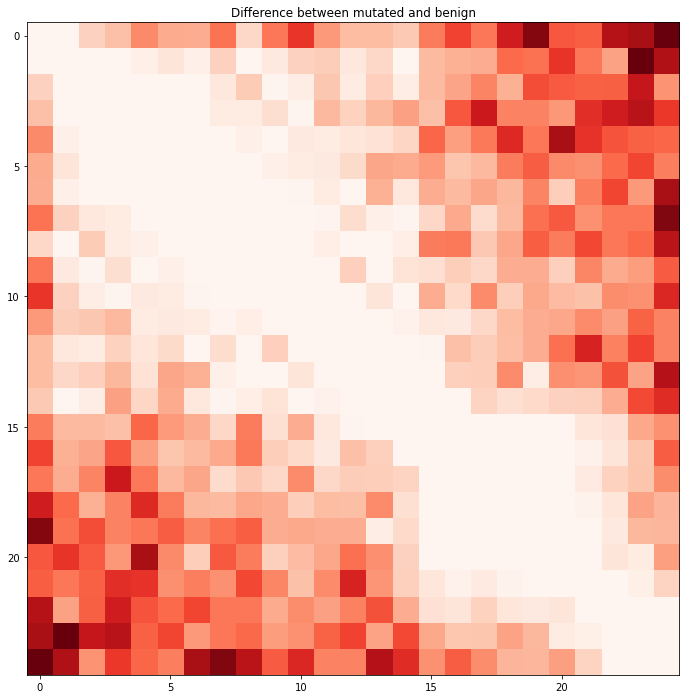

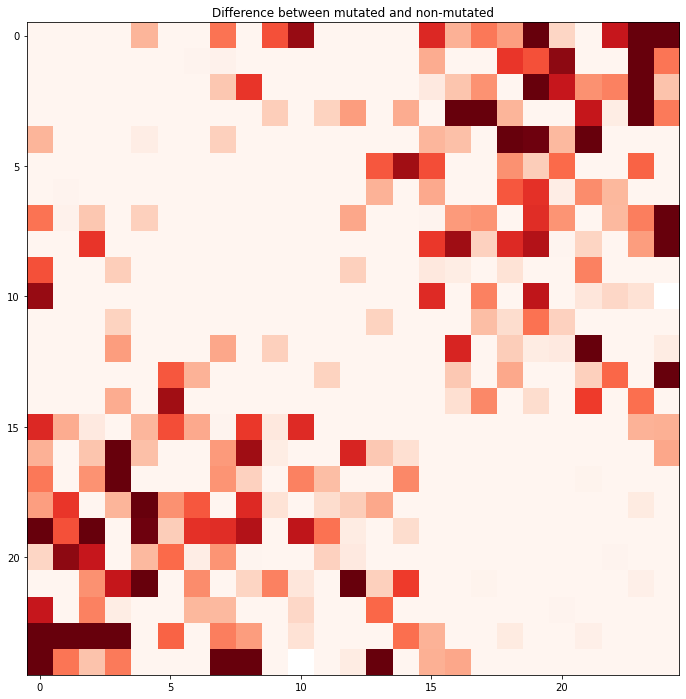

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

sv_sample_id = "PCa13848"
nonsv_sample_id = "PCa53687"
pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr14", 35225000, hg38),
        nc.chr_pos_to_genome_pos("chr14", 36025000, hg38),
    ],
}

def filter_arr(x):
    return x[~np.isnan(x) & np.isfinite(x)]

mut = Cooler(path.join("..", "..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts", sv_sample_id + ".mcool::/resolutions/20000"))
nonmut = Cooler(path.join("..", "..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts", nonsv_sample_id + ".mcool::/resolutions/20000"))
benigns = {
    s: Cooler(
        path.join("..", "..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts", s + ".mcool::/resolutions/20000")
    ) for s in benign_samples
}

# get contact matrix values around the breakpoint
i, j = mut.extent("chr14:35400000-35900000")
mut_mat = mut.matrix()[i:j, i:j]
nonmut_mat = nonmut.matrix()[i:j, i:j]
benign_mat = np.mean([benigns[s].matrix()[i:j, i:j] for s in benign_samples])

# calculate the difference between the two contact matrices
# (< 0: more contacts in mutant, > 0: fewer contacts in mutant)
diff = {
    "nonmut": np.log10(nonmut_mat / mut_mat),
    "benign": np.log10(benign_mat / mut_mat),
}
print(diff["nonmut"].shape)
print([filter_arr(diff["nonmut"]).min(), filter_arr(diff["nonmut"]).max()])
print([filter_arr(diff["benign"]).min(), filter_arr(diff["benign"]).max()])

overlapping = {
    "nonmut": np.append(diff["nonmut"][0:16, 0:16].flatten(), diff["nonmut"][16:, 16:].flatten()),
    "benign": np.append(diff["benign"][0:16, 0:16].flatten(), diff["benign"][16:, 16:].flatten()),
}
broken = {
    "nonmut": diff["nonmut"][0:16, 16:].flatten(),
    "benign": diff["benign"][0:16, 16:].flatten(),
}

ttest_res = {
    "nonmut": stats.ttest_ind(
        a = filter_arr(broken["nonmut"]),
        b = filter_arr(overlapping["nonmut"]),
        equal_var=False,
    ),
    "benign": stats.ttest_ind(
        a = filter_arr(broken["benign"]),
        b = filter_arr(overlapping["benign"]),
        equal_var=False,
    ),
}
print(ttest_res)

# plot differences between mutant and nonmutant/benign samples
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title("Difference between mutated and benign")
plt.imshow(diff["benign"], vmin=0, vmax=1.2, cmap="Reds")
ax.set_aspect('equal')
fig.savefig("diff-benign.altered-TAD.pdf")

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title("Difference between mutated and non-mutated")
plt.imshow(diff["nonmut"], vmin=-0.1, vmax=0.3, cmap="Reds")
ax.set_aspect('equal')
fig.savefig("diff-nonmut.altered-TAD.pdf")

## A structural variant that does not affect local TAD boundaries with differential gene expression

In [58]:
sv_sample_id = "PCa51852"
nonsv_sample_id = "PCa13266"

pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr12", 5559445, hg38),
        nc.chr_pos_to_genome_pos("chr12", 7919445, hg38)
    ],
    "y": [
        nc.chr_pos_to_genome_pos("chr2", 10482496, hg38),
        nc.chr_pos_to_genome_pos("chr2", 11880637, hg38)
    ]
}
v = View(
    tracks=[
        chrom_labels["top"],
        gene_annots["top"],
        chrom_labels["left"],
        gene_annots["left"],
        lowc_heatmaps[sv_sample_id]["top"],
        lowc_heatmaps[sv_sample_id]["center"],
    ],
    initialXDomain = pos["x"],
    initialYDomain = pos["y"],
)

d, s, c = higlass.display(
    views=[v],
)
d

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'fIwiTNgiSguqG85BLvwg6g', 'tracks': {'top': [{'ty…

/home/james/miniconda3/envs/Davos/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
/home/james/miniconda3/envs/Davos/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/james/miniconda3/envs/Davos/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/home/james/miniconda3/envs/Davos/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


(50, 50)
[-0.9543337040947188, 1.2897995856728406]
[-0.45254579327228805, 1.7743447907709948]
{'nonmut': Ttest_indResult(statistic=5.249388531127014, pvalue=1.9563654953438385e-07), 'benign': Ttest_indResult(statistic=30.16218343849497, pvalue=1.4597867469298748e-151)}


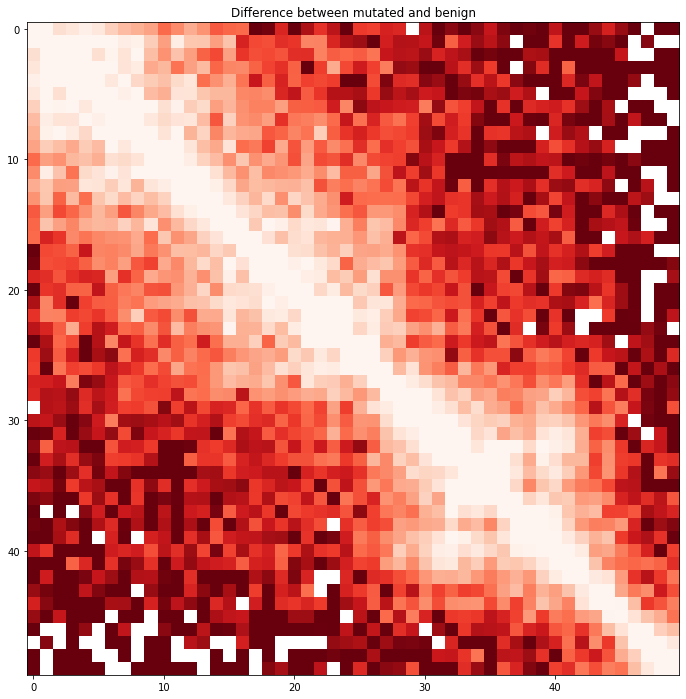

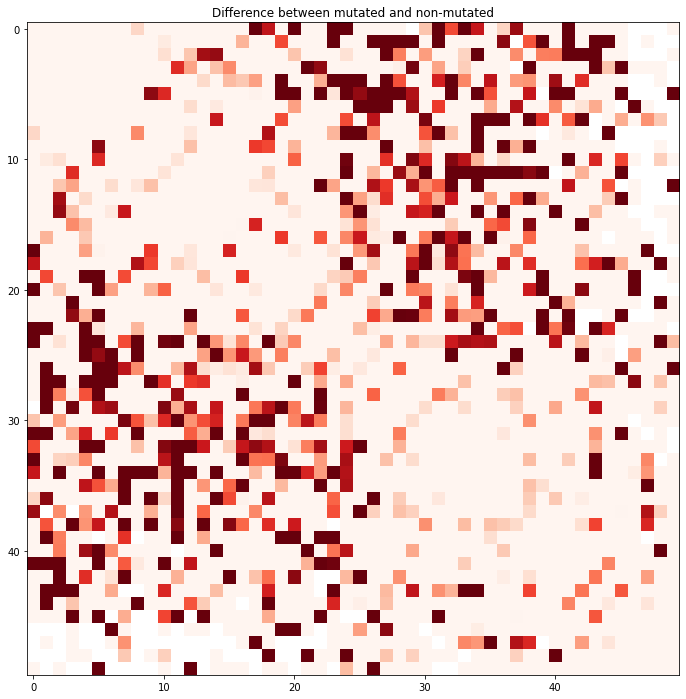

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

sv_sample_id = "PCa53687"
nonsv_sample_id = "PCa40507"
pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr12", 6300000, hg38),
        nc.chr_pos_to_genome_pos("chr12", 7300000, hg38),
    ],
}

mut = Cooler(path.join("..", "..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts", sv_sample_id + ".mcool::/resolutions/20000"))
nonmut = Cooler(path.join("..", "..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts", nonsv_sample_id + ".mcool::/resolutions/20000"))
benigns = {
    s: Cooler(
        path.join("..", "..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts", s + ".mcool::/resolutions/20000")
    ) for s in benign_samples
}

# get contact matrix values around the breakpoint
i, j = mut.extent("chr12:6300000-7300000")
mut_mat = mut.matrix()[i:j, i:j]
nonmut_mat = nonmut.matrix()[i:j, i:j]
benign_mat = np.mean([benigns[s].matrix()[i:j, i:j] for s in benign_samples])

# calculate the difference between the two contact matrices
# (< 0: more contacts in mutant, > 0: fewer contacts in mutant)
diff = {
    "nonmut": np.log10(nonmut_mat / mut_mat),
    "benign": np.log10(benign_mat / mut_mat),
}
print(diff["nonmut"].shape)
print([filter_arr(diff["nonmut"]).min(), filter_arr(diff["nonmut"]).max()])
print([filter_arr(diff["benign"]).min(), filter_arr(diff["benign"]).max()])

overlapping = {
    "nonmut": np.append(diff["nonmut"][0:25, 0:25].flatten(), diff["nonmut"][25:, 25:].flatten()),
    "benign": np.append(diff["benign"][0:25, 0:25].flatten(), diff["benign"][25:, 25:].flatten()),
}
broken = {
    "nonmut": diff["nonmut"][0:25, 25:].flatten(),
    "benign": diff["benign"][0:25, 25:].flatten(),
}

ttest_res = {
    "nonmut": stats.ttest_ind(
        a = filter_arr(broken["nonmut"]),
        b = filter_arr(overlapping["nonmut"]),
        equal_var=False,
    ),
    "benign": stats.ttest_ind(
        a = filter_arr(broken["benign"]),
        b = filter_arr(overlapping["benign"]),
        equal_var=False,
    ),
}
print(ttest_res)

# plot differences between mutant and nonmutant/benign samples
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title("Difference between mutated and benign")
plt.imshow(diff["benign"], vmin=0, vmax=1.2, cmap="Reds")
ax.set_aspect('equal')
fig.savefig("diff-benign.no-altered-TAD.pdf")

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title("Difference between mutated and non-mutated")
plt.imshow(diff["nonmut"], vmin=0.3, vmax=0.5, cmap="Reds")
ax.set_aspect('equal')
fig.savefig("diff-nonmut.no-altered-TAD.pdf")

## Exploring other breakpoints

In [83]:
zoom_offset = 1e6

# test_ID
ti = 197
# paired test_ID(s)
tj = bp_pairs.loc[bp_pairs.test_ID_x == ti, "test_ID_y"].tolist() + bp_pairs.loc[bp_pairs.test_ID_y == ti, "test_ID_x"].tolist()

# mutated sample IDs
mut_s = disruption_tests.loc[disruption_tests.test_ID == ti, "mut_samples"].values[0].split(",")
nonmut_s = disruption_tests.loc[disruption_tests.test_ID == ti, "nonmut_samples"].values[0].split(",")

# views
v = []
if len(tj) > 1:
    pos = {
        "x": {
            "chr": disruption_tads.loc[disruption_tads.test_ID == ti, "chr"].values[0],
            "start": int(disruption_tads.loc[disruption_tads.test_ID == ti, "start"].values[0]) - zoom_offset,
            "end": int(disruption_tads.loc[disruption_tads.test_ID == ti, "end"].values[0]) + zoom_offset,
        },
        "y": {
            k: {
                "chr": disruption_tads.loc[disruption_tads.test_ID == k, "chr"].values[0],
                "start": int(disruption_tads.loc[disruption_tads.test_ID == k, "start"].values[0]) - zoom_offset,
                "end": int(disruption_tads.loc[disruption_tads.test_ID == k, "end"].values[0]) + zoom_offset,
            } for k in tj
        },
    }
    v = [
        View(
            tracks=[
                chrom_labels["top"],
                gene_annots["top"],
                chrom_labels["left"],
                lowc_heatmaps[s]["center"],
            ],
            initialXDomain=[
                nc.chr_pos_to_genome_pos(pos["x"]["chr"], pos["x"]["start"], hg38),
                nc.chr_pos_to_genome_pos(pos["x"]["chr"], pos["x"]["end"], hg38)
            ],
            initialYDomain=[
                nc.chr_pos_to_genome_pos(pos["y"][k]["chr"], pos["y"][k]["start"], hg38),
                nc.chr_pos_to_genome_pos(pos["y"][k]["chr"], pos["y"][k]["end"], hg38)
            ],
        ) for s in mut_s for k in tj
    ]
    for s in nonmut_s[1:2]:
        for k in tj:
            v.append(View(
                tracks=[
                    chrom_labels["left"],
                    lowc_heatmaps[s]["center"],
                    lowc_heatmaps[s]["bottom"],
                ],
                initialXDomain=[
                    nc.chr_pos_to_genome_pos(pos["x"]["chr"], pos["x"]["start"], hg38),
                    nc.chr_pos_to_genome_pos(pos["x"]["chr"], pos["x"]["end"], hg38)
                ],
                initialYDomain=[
                    nc.chr_pos_to_genome_pos(pos["y"][k]["chr"], pos["y"][k]["start"], hg38),
                    nc.chr_pos_to_genome_pos(pos["y"][k]["chr"], pos["y"][k]["end"], hg38)
                ],
            ))
else:
    pos = {
        "x": {
            "chr": disruption_tads.loc[disruption_tads.test_ID == ti, "chr"].values[0],
            "start": int(disruption_tads.loc[disruption_tads.test_ID == ti, "start"].values[0]) - zoom_offset,
            "end": int(disruption_tads.loc[disruption_tads.test_ID == ti, "end"].values[0]) + zoom_offset,
        },
        "y": {
            "chr": disruption_tads.loc[disruption_tads.test_ID == tj[0], "chr"].values[0],
            "start": int(disruption_tads.loc[disruption_tads.test_ID == tj[0], "start"].values[0]) - zoom_offset,
            "end": int(disruption_tads.loc[disruption_tads.test_ID == tj[0], "end"].values[0]) + zoom_offset,
        },
    }
    v = [
        View(
            tracks=[
                chrom_labels["top"],
                gene_annots["top"],
                chrom_labels["left"],
                lowc_heatmaps[s]["center"],
                lowc_heatmaps[s]["bottom"],
            ],
            initialXDomain=[
                nc.chr_pos_to_genome_pos(pos["x"]["chr"], pos["x"]["start"], hg38),
                nc.chr_pos_to_genome_pos(pos["x"]["chr"], pos["x"]["end"], hg38)
            ],
            initialYDomain=[
                nc.chr_pos_to_genome_pos(pos["y"]["chr"], pos["y"]["start"], hg38),
                nc.chr_pos_to_genome_pos(pos["y"]["chr"], pos["y"]["end"], hg38)
            ],
        ) for s in mut_s
    ]
    
    for s in nonmut_s[1:2]:
        v.append(View(
            tracks=[
                chrom_labels["left"],
                lowc_heatmaps[s]["center"],
                lowc_heatmaps[s]["bottom"],
            ],
            initialXDomain=[
                nc.chr_pos_to_genome_pos(pos["x"]["chr"], pos["x"]["start"], hg38),
                nc.chr_pos_to_genome_pos(pos["x"]["chr"], pos["x"]["end"], hg38)
            ],
            initialYDomain=[
                nc.chr_pos_to_genome_pos(pos["y"]["chr"], pos["y"]["start"], hg38),
                nc.chr_pos_to_genome_pos(pos["y"]["chr"], pos["y"]["end"], hg38)
            ],
        ))


print(mut_s)
print(nonmut_s)
print(pos)
display, server, viewconf = higlass.display(
    views=v,
    zoom_syncs=[v],
#    location_syncs=[v],
#    value_scale_syncs=[
#        [(v[s], lowc_heatmaps[s]["top"]) for s in v]
#    ],
    server_port=8192
)

display

['PCa53687']
['PCa13266', 'PCa13848', 'PCa14121', 'PCa19121', 'PCa3023', 'PCa33173', 'PCa40507', 'PCa51852', 'PCa56413', 'PCa57294']
{'x': {'chr': 'chr7', 'start': 106330000.0, 'end': 108840000.0}, 'y': {'chr': 'chr1', 'start': 230620000.0, 'end': 233750000.0}}


HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'Ha2HmiwwTeatehfMR26ncQ', 'tracks': {'top': [{'ty…

# Images
## Important prostate cancer regions

In [10]:
sample_tracks = [chrom_labels["top"], gene_annots["top"]] + [lowc_heatmaps[s]["top"] for s in all_samples[::-1]]
tumour_tracks = [chrom_labels["top"], gene_annots["top"]] + [lowc_heatmaps[s]["top"] for s in tumour_samples]

### FOXA1

In [18]:
foxa1_view = View(
    tracks=sample_tracks,
    initialXDomain=[
        nc.chr_pos_to_genome_pos("chr14", 36000000, hg38),
        nc.chr_pos_to_genome_pos("chr14", 39000000, hg38)
    ],
)

display, server, viewconf = higlass.display(
    [foxa1_view],
    value_scale_syncs=[
        [(foxa1_view, lowc_heatmaps[s]["top"]) for s in all_samples]
    ],
    server_port=8192,
)
display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'El1Cw0kTTritNvpESa4vrg', 'tracks': {'top': [{'ty…

In [20]:
print("This: {}".format(display.dom_element_id))
#save_as_png(display, path.join(os.getcwd(), "Plots", "FOXA1-locus.v2.png"))
save_as_png(display, path.join("Plots", "FOXA1-locus.v2.png"))

This: 0veffb


NameError: name 'save_as_png' is not defined

### _TMPRSS2 - ERG_ fusion

In [11]:
t2e_view = View(
    tracks=tumour_tracks,
    initialXDomain=[
        nc.chr_pos_to_genome_pos("chr21", 35000000, hg38),
        nc.chr_pos_to_genome_pos("chr21", 43000000, hg38)
    ],
)

display, server, viewconf = higlass.display(
    views=[t2e_view],
    value_scale_syncs = [
        [(t2e_view, lowc_heatmaps[s]["top"]) for s in tumour_samples],
    ],
    #zoom_syncs=[
    #    [(t2e_view, lowc_heatmaps[s]["center"]) for s in tumour_samples],
    #],
    #location_syncs=[
    #    [(t2e_view, lowc_heatmaps[s]["center"]) for s in tumour_samples],
    #],
    server_port=8192
)
display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'e9Lfnuv7SNSoaRv4Uz6Ulw', 'tracks': {'top': [{'ty…

### AR

In [23]:
ar_view = View(
    tracks=sample_tracks,
    initialXDomain=[
        nc.chr_pos_to_genome_pos("chrX", 65800000, hg38),
        nc.chr_pos_to_genome_pos("chrX", 68700000, hg38)
    ]
)

display, server, viewconf = higlass.display(
    [ar_view],
    value_scale_syncs = [
        [(ar_view, lowc_heatmaps[s]["top"]) for s in all_samples]
    ],
    server_port=8192,
)
display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'JdyFubg-R2-66OQ1TFUxow', 'tracks': {'top': [{'ty…

### MYC

In [24]:
myc_view = View(
    tracks=sample_tracks,
    initialXDomain=[
        nc.chr_pos_to_genome_pos("chr8", 126000000, hg38),
        nc.chr_pos_to_genome_pos("chr8", 130000000, hg38)
    ],
)

display, server, viewconf = higlass.display(
    [myc_view],
    value_scale_syncs=[
        [(myc_view, lowc_heatmaps[s]["top"]) for s in all_samples]
    ],
    server_port=8192,
)
display


HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'SQ_PXsdOTaau3ltyrKoLlQ', 'tracks': {'top': [{'ty…

### HOXB13

In [25]:
hoxb13_view = View(
    tracks=sample_tracks,
    initialXDomain=[
        nc.chr_pos_to_genome_pos("chr17", 46160000, hg38),
        nc.chr_pos_to_genome_pos("chr17", 51320000, hg38)
    ],
)
display, server, viewconf = higlass.display(
    [hoxb13_view],
    value_scale_syncs=[
        [(hoxb13_view, lowc_heatmaps[s]["top"]) for s in all_samples]
    ],
    server_port=8192,
)
display


HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'XORqkA-4RxuSUVqkhmpf2A', 'tracks': {'top': [{'ty…

### KLK Cluster

In [12]:
klk_view = View(
    tracks=sample_tracks,
    #tracks = [chrom_labels["top"], gene_annots["top"]],
    initialXDomain=[
        nc.chr_pos_to_genome_pos("chr19", 49000000, hg38),
        nc.chr_pos_to_genome_pos("chr19", 53000000, hg38)
    ],
)
display, server, viewconf = higlass.display(
    [klk_view],
    value_scale_syncs=[
        [(klk_view, lowc_heatmaps[s]["top"]) for s in all_samples]
    ],
    server_port=8192,
)
display


HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'coYkGqDnSiu23Z7eqM5Geg', 'tracks': {'top': [{'ty…

In [ ]:
myc_insertion_view = View(
    tracks=[chrom_labels["top"], gene_annots["top"]] + [lowc_heatmaps[s]["top"] for s in all_samples],
    initialXDomain=[
        nc.chr_pos_to_genome_pos("chr12", 70480000 - 5e6, hg38),
        nc.chr_pos_to_genome_pos("chr12", 70570000 + 5e6, hg38)
    ],
)

display, server, viewconf = higlass.display([
    myc_insertion_view
])
display

# Structural variants and novel COREs

## COL1A1

### Rearrangement

In [24]:
mut_s = "PCa40507"
nonmut_s = "PCa13266"
zoom_offset = 1e5

pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr17", 50100000 - zoom_offset, hg38),
        nc.chr_pos_to_genome_pos("chr17", 50400000 + zoom_offset, hg38),
    ],
    "y": [
        [
            nc.chr_pos_to_genome_pos("chr17", 11300000 - zoom_offset, hg38),
            nc.chr_pos_to_genome_pos("chr17", 11800000 + zoom_offset, hg38),   
        ],
        [
            nc.chr_pos_to_genome_pos("chr2", 6726000 - zoom_offset, hg38),
            nc.chr_pos_to_genome_pos("chr2", 7064000 + zoom_offset, hg38),
        ]
    ]
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            chip[mut_s]["top"],
            peaks[mut_s]["top"],
            cores[mut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            chrom_labels["left"],
            chip[mut_s]["left"],
            peaks[mut_s]["left"],
            cores[mut_s]["left"],
            CombinedTrack([lowc_heatmaps[mut_s]["center"], break_tracks_2D[mut_s]["centre"]]),
            lowc_heatmaps[mut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"][0],
    ),
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            chip[nonmut_s]["top"],
            peaks[nonmut_s]["top"],
            cores[nonmut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            chrom_labels["left"],
            chip[nonmut_s]["left"],
            peaks[nonmut_s]["left"],
            cores[nonmut_s]["left"],
            CombinedTrack([lowc_heatmaps[nonmut_s]["center"], break_tracks_2D[mut_s]["centre"]]),
            lowc_heatmaps[nonmut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"][0],
    ),
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            chip[mut_s]["top"],
            peaks[mut_s]["top"],
            cores[mut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            chrom_labels["left"],
            chip[mut_s]["left"],
            peaks[mut_s]["left"],
            cores[mut_s]["left"],
            CombinedTrack([lowc_heatmaps[mut_s]["center"], break_tracks_2D[mut_s]["centre"]]),
            lowc_heatmaps[mut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"][1],
    ),
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            chip[nonmut_s]["top"],
            peaks[nonmut_s]["top"],
            cores[nonmut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            chrom_labels["left"],
            chip[nonmut_s]["left"],
            peaks[nonmut_s]["left"],
            cores[nonmut_s]["left"],
            CombinedTrack([lowc_heatmaps[nonmut_s]["center"], break_tracks_2D[mut_s]["centre"]]),
            lowc_heatmaps[nonmut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"][1],
    ),
]

display, server, viewconf = higlass.display(
    views=v,
    zoom_syncs=[v],
    location_syncs=[
        v[0:2],
        v[2:4]
    ],
    value_scale_syncs=[
        [(v[0], chip[mut_s]["top"]), (v[1], chip[nonmut_s]["top"])],
        [(v[0], chip[mut_s]["left"]), (v[1], chip[nonmut_s]["left"])],
        [(v[2], chip[mut_s]["top"]), (v[3], chip[nonmut_s]["top"])],
        [(v[2], chip[mut_s]["left"]), (v[3], chip[nonmut_s]["left"])],
        [(v[0], chip[mut_s]["top"]), (v[0], chip[mut_s]["left"])],
        [(v[2], chip[mut_s]["top"]), (v[2], chip[mut_s]["left"])],
        [(v[0], lowc_heatmaps[mut_s]["center"]), (v[1], lowc_heatmaps[nonmut_s]["center"])],
        [(v[0], lowc_heatmaps[mut_s]["bottom"]), (v[1], lowc_heatmaps[nonmut_s]["bottom"])],
        [(v[2], lowc_heatmaps[mut_s]["center"]), (v[3], lowc_heatmaps[nonmut_s]["center"])],
        [(v[2], lowc_heatmaps[mut_s]["bottom"]), (v[3], lowc_heatmaps[nonmut_s]["bottom"])],
    ],
    server_port=8192
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'JYMCYMtHRI2y0cjBYMHgcA', 'tracks': {'top': [{'ty…

### All acetylation

In [23]:
mut_s = "PCa40507"
zoom_offset = 1e5

pos = [
    [
        nc.chr_pos_to_genome_pos("chr17", 50100000 - zoom_offset, hg38),
        nc.chr_pos_to_genome_pos("chr17", 50500000 + zoom_offset, hg38),
    ],
    [
        nc.chr_pos_to_genome_pos("chr17", 11300000 - zoom_offset, hg38),
        nc.chr_pos_to_genome_pos("chr17", 11800000 + zoom_offset, hg38),   
    ],
    [
        nc.chr_pos_to_genome_pos("chr2", 3700000 - zoom_offset, hg38),
        nc.chr_pos_to_genome_pos("chr2", 6890000 + zoom_offset, hg38),
    ]
]


comb_tracks = {
    "chip": CombinedTrack([chip[s]["top"] for s in tumour_samples if s != mut_s]),
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            break_tracks_1D[mut_s]["top"],
            chip[mut_s]["top"],
            cores[mut_s]["top"],
            peaks[mut_s]["top"],
            comb_tracks["chip"],
        ] + [
            peaks[s]["top"] for s in tumour_samples if s != mut_s
        ] + [
            cores[s]["top"] for s in tumour_samples if s != mut_s
        ],
        initialXDomain=p,
    )
    for p in pos
]

display, server, viewconf = higlass.display(
    views=v,
    zoom_syncs=[v],
    value_scale_syncs=[
        [(v[0], chip[s]["top"]) for s in tumour_samples],
        [(v[1], chip[s]["top"]) for s in tumour_samples],
        [(v[2], chip[s]["top"]) for s in tumour_samples],
    ],
    server_port=8192
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'cR4jr4DNTb2QIlPhSlGn_w', 'tracks': {'top': [{'ty…

### Paired acetylation

In [12]:
nonmut_s = "PCa13848"
mut_s = "PCa40507"
zoom_offset = 1e5

pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr17", 49964536, hg38),
        nc.chr_pos_to_genome_pos("chr17", 50380091, hg38),
    ],
    "y": [
        nc.chr_pos_to_genome_pos("chr17", 11300000 - zoom_offset, hg38),
        nc.chr_pos_to_genome_pos("chr17", 11800000 + zoom_offset, hg38),
    ]
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            break_tracks_1D[mut_s]["top"],
            chip[mut_s]["top"],
            cores[mut_s]["top"],
            peaks[mut_s]["top"],
            chip[nonmut_s]["top"],
            cores[nonmut_s]["top"],
            peaks[nonmut_s]["top"],
        ],
        initialXDomain=pos["x"],
    )
]

display, server, viewconf = higlass.display(
    views=v,
    zoom_syncs=[v],
    location_syncs=[v],
    value_scale_syncs=[
        [(v[0], chip[mut_s]["top"]), (v[0], chip[nonmut_s]["top"])],
    ],
    server_port=8192
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'QzF4QCz6T8Ou19hXZoWmsg', 'tracks': {'top': [{'ty…

### ZNF516 & PMEPA1

### Rearrangement

In [9]:
mut_s = "PCa13848"
nonmut_s = "PCa40507"

pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr18", 76200000, hg38),
        nc.chr_pos_to_genome_pos("chr18", 76600000, hg38),
    ],
    "y": [
        nc.chr_pos_to_genome_pos("chr20", 57600000, hg38),
        nc.chr_pos_to_genome_pos("chr20", 57800000, hg38),
    ]
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            break_tracks_1D[mut_s]["top"],
            chip[mut_s]["top"],
            peaks[mut_s]["top"],
            cores[mut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            chrom_labels["left"],
            break_tracks_1D[mut_s]["left"],
            chip[mut_s]["left"],
            peaks[mut_s]["left"],
            cores[mut_s]["left"],
            CombinedTrack([lowc_heatmaps[mut_s]["center"], break_tracks_2D[mut_s]["centre"]]),
            lowc_heatmaps[mut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"],
    ),
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            chip[nonmut_s]["top"],
            peaks[nonmut_s]["top"],
            cores[nonmut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            chip[nonmut_s]["left"],
            peaks[nonmut_s]["left"],
            cores[nonmut_s]["left"],
            CombinedTrack([lowc_heatmaps[nonmut_s]["center"], break_tracks_2D[mut_s]["centre"]]),
            lowc_heatmaps[nonmut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"],
    ),
]

display, server, viewconf = higlass.display(
    views=v,
    zoom_syncs=[v],
    location_syncs=[v],
    value_scale_syncs=[
        [(v[0], chip[mut_s]["top"]), (v[1], chip[nonmut_s]["top"])],
        [(v[0], chip[mut_s]["left"]), (v[1], chip[nonmut_s]["left"])],
        [(v[0], chip[mut_s]["top"]), (v[0], chip[mut_s]["left"])],
        [(v[0], lowc_heatmaps[mut_s]["center"]), (v[1], lowc_heatmaps[nonmut_s]["center"])],
        [(v[0], lowc_heatmaps[mut_s]["bottom"]), (v[1], lowc_heatmaps[nonmut_s]["bottom"])],
    ],
    server_port=8192
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'QiuGr526R3aQc6D7XR37eA', 'tracks': {'top': [{'ty…

### All acetylation

In [10]:
mut_s = "PCa13848"
zoom_offset = 1e5

pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr18", 76200000, hg38),
        nc.chr_pos_to_genome_pos("chr18", 76600000, hg38),
    ],
    "y": [
        nc.chr_pos_to_genome_pos("chr20", 57600000, hg38),
        nc.chr_pos_to_genome_pos("chr20", 57800000, hg38),
    ]
}

comb_tracks = {
    "chip": CombinedTrack([chip[s]["top"] for s in tumour_samples if s != mut_s]),
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            break_tracks_1D[mut_s]["top"],
            chip[mut_s]["top"],
            cores[mut_s]["top"],
            peaks[mut_s]["top"],
            comb_tracks["chip"],
        ] + [
            peaks[s]["top"] for s in tumour_samples if s != mut_s
        ] + [
            cores[s]["top"] for s in tumour_samples if s != mut_s
        ],
        initialXDomain=p,
    ) for p in pos.values()
]

display, server, viewconf = higlass.display(
    views=v,
    zoom_syncs=[v],
    #location_syncs=[v],
    value_scale_syncs=[
        [(v[0], chip[s]["top"]) for s in tumour_samples],
        [(v[1], chip[s]["top"]) for s in tumour_samples],
    ],
    server_port=8192
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'MsIvwS5JTwGpEuDEVBo6Ww', 'tracks': {'top': [{'ty…

### Paired acetylation

## TMPRSS2 & ERG
### Rearrangement

In [9]:
mut_s = "PCa13848"
nonmut_s = "PCa13266"
zoom_offset = 1e5

pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr21", 38400000 - zoom_offset, hg38),
        nc.chr_pos_to_genome_pos("chr21", 38780000 + zoom_offset, hg38),
    ],
    "y": [
        nc.chr_pos_to_genome_pos("chr21", 41450000 - zoom_offset, hg38),
        nc.chr_pos_to_genome_pos("chr21", 41620000 + zoom_offset, hg38),   
    ]
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            chip[mut_s]["top"],
            peaks[mut_s]["top"],
            cores[mut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            chrom_labels["left"],
            chip[mut_s]["left"],
            peaks[mut_s]["left"],
            cores[mut_s]["left"],
            CombinedTrack([lowc_heatmaps[mut_s]["center"], break_tracks_2D[mut_s]["centre"]]),
            lowc_heatmaps[mut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"],
    ),
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            chip[nonmut_s]["top"],
            peaks[nonmut_s]["top"],
            cores[nonmut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            chrom_labels["left"],
            chip[nonmut_s]["left"],
            peaks[nonmut_s]["left"],
            cores[nonmut_s]["left"],
            CombinedTrack([lowc_heatmaps[nonmut_s]["center"], break_tracks_2D[mut_s]["centre"]]),
            lowc_heatmaps[nonmut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"],
    ),
]

display, server, viewconf = higlass.display(
    views=v,
    zoom_syncs=[v],
    location_syncs=[
        v[0:2],
        v[2:4]
    ],
    value_scale_syncs=[
        [(v[0], chip[mut_s]["top"]), (v[1], chip[nonmut_s]["top"])],
        [(v[0], chip[mut_s]["left"]), (v[1], chip[nonmut_s]["left"])],
        [(v[0], chip[mut_s]["top"]), (v[0], chip[mut_s]["left"])],
        [(v[0], lowc_heatmaps[mut_s]["center"]), (v[1], lowc_heatmaps[nonmut_s]["center"])],
        [(v[0], lowc_heatmaps[mut_s]["bottom"]), (v[1], lowc_heatmaps[nonmut_s]["bottom"])],
    ],
    server_port=8192
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'e_JH2E8RT52MgmRK3wmKkA', 'tracks': {'top': [{'ty…

### All acetylation

In [10]:
zoom_offset = 1e5

pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr21", 38400000 - zoom_offset, hg38),
        nc.chr_pos_to_genome_pos("chr21", 38780000 + zoom_offset, hg38),
    ],
    "y": [
        nc.chr_pos_to_genome_pos("chr21", 41450000 - zoom_offset, hg38),
        nc.chr_pos_to_genome_pos("chr21", 41620000 + zoom_offset, hg38),   
    ]
}

comb_tracks = {
    "T2E": CombinedTrack([chip[s]["top"] for s in t2e_samples]),
    "non-T2E": CombinedTrack([chip[s]["top"] for s in nont2e_samples]),
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            break_tracks_1D[mut_s]["top"],
            comb_tracks["T2E"],
            comb_tracks["non-T2E"],
        ] + [
            peaks[s]["top"] for s in t2e_samples
        ] + [
            cores[s]["top"] for s in t2e_samples
        ] + [
            peaks[s]["top"] for s in nont2e_samples
        ] + [
            cores[s]["top"] for s in nont2e_samples
        ],
        initialXDomain=p,
    ) for p in pos.values()
]

display, server, viewconf = higlass.display(
    views=v,
    zoom_syncs=[v],
    #location_syncs=[v],
    value_scale_syncs=[
        [(v[0], chip[s]["top"]) for s in tumour_samples],
        [(v[1], chip[s]["top"]) for s in tumour_samples],
    ],
    server_port=8192
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'fgGdHwXoTwmDZxI4aA7Q_Q', 'tracks': {'top': [{'ty…

## ZBTB24 & ELK4

### Rearrangement

In [18]:
mut_s = "PCa13848"
nonmut_s = "PCa13266"
zoom_offset = 1e5

pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr6", 110500000 - zoom_offset, hg38),
        nc.chr_pos_to_genome_pos("chr6", 110500000 + zoom_offset, hg38),
    ],
    "y": [
        nc.chr_pos_to_genome_pos("chr1", 205650000 - zoom_offset, hg38),
        nc.chr_pos_to_genome_pos("chr1", 205650000 + zoom_offset, hg38),   
    ]
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            chip[mut_s]["top"],
            peaks[mut_s]["top"],
            cores[mut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            chrom_labels["left"],
            chip[mut_s]["left"],
            peaks[mut_s]["left"],
            cores[mut_s]["left"],
            CombinedTrack([lowc_heatmaps[mut_s]["center"], break_tracks_2D[mut_s]["centre"]]),
            lowc_heatmaps[mut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"],
    ),
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            chip[nonmut_s]["top"],
            peaks[nonmut_s]["top"],
            cores[nonmut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            chrom_labels["left"],
            chip[nonmut_s]["left"],
            peaks[nonmut_s]["left"],
            cores[nonmut_s]["left"],
            CombinedTrack([lowc_heatmaps[nonmut_s]["center"], break_tracks_2D[mut_s]["centre"]]),
            lowc_heatmaps[nonmut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"],
    ),
]

display, server, viewconf = higlass.display(
    views=v,
    zoom_syncs=[v],
    location_syncs=[
        v[0:2],
        v[2:4]
    ],
    value_scale_syncs=[
        [(v[0], chip[mut_s]["top"]), (v[1], chip[nonmut_s]["top"])],
        [(v[0], chip[mut_s]["left"]), (v[1], chip[nonmut_s]["left"])],
        [(v[0], chip[mut_s]["top"]), (v[0], chip[mut_s]["left"])],
        [(v[0], lowc_heatmaps[mut_s]["center"]), (v[1], lowc_heatmaps[nonmut_s]["center"])],
        [(v[0], lowc_heatmaps[mut_s]["bottom"]), (v[1], lowc_heatmaps[nonmut_s]["bottom"])],
    ],
    server_port=8192
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'ETEwucwgSvm9YP5y7SmaFA', 'tracks': {'top': [{'ty…

### All acetylation

In [16]:
zoom_offset = 1e5

pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr6", 110500000 - zoom_offset, hg38),
        nc.chr_pos_to_genome_pos("chr6", 110500000 + zoom_offset, hg38),
    ],
    "y": [
        nc.chr_pos_to_genome_pos("chr1", 205650000 - zoom_offset, hg38),
        nc.chr_pos_to_genome_pos("chr1", 205650000 + zoom_offset, hg38),   
    ]
}

comb_tracks = {
    "mut": CombinedTrack([chip[s]["top"] for s in tumour_samples if s == mut_s]),
    "nonmut": CombinedTrack([chip[s]["top"] for s in tumour_samples if s != mut_s]),
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            break_tracks_1D[mut_s]["top"],
            comb_tracks["mut"],
        ] + [
            peaks[s]["top"] for s in tumour_samples if s == mut_s
        ] + [
            cores[s]["top"] for s in tumour_samples if s == mut_s
        ] + [
            comb_tracks["nonmut"],
        ] + [
            peaks[s]["top"] for s in tumour_samples if s != mut_s
        ] + [
            cores[s]["top"] for s in tumour_samples if s != mut_s
        ],
        initialXDomain=p,
    ) for p in pos.values()
]

display, server, viewconf = higlass.display(
    views=v,
    zoom_syncs=[v],
    #location_syncs=[v],
    value_scale_syncs=[
        [(v[0], chip[s]["top"]) for s in tumour_samples],
        [(v[1], chip[s]["top"]) for s in tumour_samples],
    ],
    server_port=8192
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'O4wkomI1TruN-rfMa6ixMw', 'tracks': {'top': [{'ty…

## Other example

### Rearrangement

In [20]:
mut_s = "PCa13848"
nonmut_s = "PCa13266"
zoom_offset = 1e5

pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr5", 172400000 - zoom_offset, hg38),
        nc.chr_pos_to_genome_pos("chr5", 173000000 + zoom_offset, hg38),
    ],
    "y": [
        nc.chr_pos_to_genome_pos("chr5", 59000000 - zoom_offset, hg38),
        nc.chr_pos_to_genome_pos("chr5", 59200000 + zoom_offset, hg38),
    ]
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            chip[mut_s]["top"],
            peaks[mut_s]["top"],
            cores[mut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            chrom_labels["left"],
            chip[mut_s]["left"],
            peaks[mut_s]["left"],
            cores[mut_s]["left"],
            CombinedTrack([lowc_heatmaps[mut_s]["center"], break_tracks_2D[mut_s]["centre"]]),
            lowc_heatmaps[mut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"],
    ),
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            chip[nonmut_s]["top"],
            peaks[nonmut_s]["top"],
            cores[nonmut_s]["top"],
            chrom_labels["left"],
            gene_annots["left"],
            chrom_labels["left"],
            chip[nonmut_s]["left"],
            peaks[nonmut_s]["left"],
            cores[nonmut_s]["left"],
            CombinedTrack([lowc_heatmaps[nonmut_s]["center"], break_tracks_2D[mut_s]["centre"]]),
            lowc_heatmaps[nonmut_s]["bottom"],
        ],
        initialXDomain=pos["x"],
        initialYDomain=pos["y"],
    ),
]

display, server, viewconf = higlass.display(
    views=v,
    zoom_syncs=[v],
    location_syncs=[
        v[0:2],
        v[2:4]
    ],
    value_scale_syncs=[
        [(v[0], chip[mut_s]["top"]), (v[1], chip[nonmut_s]["top"])],
        [(v[0], chip[mut_s]["left"]), (v[1], chip[nonmut_s]["left"])],
        [(v[0], chip[mut_s]["top"]), (v[0], chip[mut_s]["left"])],
        [(v[0], lowc_heatmaps[mut_s]["center"]), (v[1], lowc_heatmaps[nonmut_s]["center"])],
        [(v[0], lowc_heatmaps[mut_s]["bottom"]), (v[1], lowc_heatmaps[nonmut_s]["bottom"])],
    ],
    server_port=8192
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'SAyTqEsXRuunk-35AD5mjA', 'tracks': {'top': [{'ty…

### All acetylation

In [21]:
zoom_offset = 1e5

pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr5", 172400000 - zoom_offset, hg38),
        nc.chr_pos_to_genome_pos("chr5", 173000000 + zoom_offset, hg38),
    ],
    "y": [
        nc.chr_pos_to_genome_pos("chr5", 59000000 - zoom_offset, hg38),
        nc.chr_pos_to_genome_pos("chr5", 59200000 + zoom_offset, hg38),
    ]
}

comb_tracks = {
    "mut": CombinedTrack([chip[s]["top"] for s in tumour_samples if s == mut_s]),
    "nonmut": CombinedTrack([chip[s]["top"] for s in tumour_samples if s != mut_s]),
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            break_tracks_1D[mut_s]["top"],
            comb_tracks["mut"],
        ] + [
            peaks[s]["top"] for s in tumour_samples if s == mut_s
        ] + [
            cores[s]["top"] for s in tumour_samples if s == mut_s
        ] + [
            comb_tracks["nonmut"],
        ] + [
            peaks[s]["top"] for s in tumour_samples if s != mut_s
        ] + [
            cores[s]["top"] for s in tumour_samples if s != mut_s
        ],
        initialXDomain=p,
    ) for p in pos.values()
]

display, server, viewconf = higlass.display(
    views=v,
    zoom_syncs=[v],
    #location_syncs=[v],
    value_scale_syncs=[
        [(v[0], chip[s]["top"]) for s in tumour_samples],
        [(v[1], chip[s]["top"]) for s in tumour_samples],
    ],
    server_port=8192
)

display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'YxbZcsVkR4mouzVtW3aOMQ', 'tracks': {'top': [{'ty…

In [6]:
insulation = {
    "diff": Track(
        track_type="horizontal-line",
        position="top",
        tileset=bigwig("../2020-08-29_TADs-downsampled/Insulation/difftl-insulation.malignant-benign.bw"),
        filetype="vector",
        height=100,
        options={
            "showMousePosition": True,
            "name": "Malignant vs Benign Insulation",
            "valueScaleMin": -2,
            "valueScaleMax": 2,
            "zeroLineColor": "#000000",
            "zeroLineVisible": True,
            # "zeroLineOpacity": 1,
        },
    ),
    "tumour": Track(
        track_type="horizontal-line",
        position="top",
        tileset=bigwig("../2020-08-29_TADs-downsampled/Insulation/difftl-insulation.malignant.bw"),
        filetype="vector",
        height=100,
        options={
            "showMousePosition": True,
            "name": "Tumour Insulation",
        },
    ),
    "benign": Track(
        track_type="horizontal-line",
        position="top",
        tileset=bigwig("../2020-08-29_TADs-downsampled/Insulation/difftl-insulation.benign.bw"),
        filetype="vector",
        height=100,
        options={
            "showMousePosition": True,
            "name": "Tumour Insulation",
        },
    ),
}

test_view = View(
    tracks=[
        gene_annots["top"],
        chrom_labels["top"],
        lowc_heatmaps["PCa13266"]["top"],
        lowc_heatmaps["SRR7702334"]["top"],
        lowc_heatmaps["Benign-Prostate-1595983"]["top"],
        lowc_heatmaps["SRR8446383"]["top"],
    ],
    initialXDomain=[
        nc.chr_pos_to_genome_pos("chrX", 68e6 - 3e6, hg38),
        nc.chr_pos_to_genome_pos("chrX", 68e6 + 3e6, hg38),
    ]
)

d, s, v = higlass.display(
    views=[test_view],
    # value_scale_syncs=[
    #     [(test_view, lowc_heatmaps[s]["top"]) for s in ["PCa13266", "SRR7702334", "Benign-Prostate-1595983", "SRR8446383"]]
    # ],
)
d

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'fK47XBvhQFi4TcLllh_eqQ', 'tracks': {'top': [{'ty…